In [5]:
import random
import torch
from d2l import torch as d2l

In [7]:
def synthetic_data(w, b, num_examples):  #@save
    """
    生成y=Xw+b+噪声
    需要传入真实的w和b
    """
    # num_examples个样本，列数为len(w)
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    # 为了更真实一点，增加一个随机噪音
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
# 生成特征和标注
features, labels = synthetic_data(true_w, true_b, 1000)

In [12]:
# 稍微看一下数据的样式
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([0.9361, 0.7102]) 
label: tensor([3.6661])


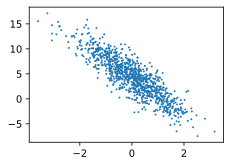

In [14]:
# 稍微看一下数据的样式
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

In [16]:
# 打乱数据，提取小批量
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        # 用yield字段转为迭代器
        yield features[batch_indices], labels[batch_indices]

In [18]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.0218,  1.7542],
        [ 2.0093,  0.3451],
        [ 0.5795, -0.2668],
        [ 0.6588, -0.1065],
        [-0.5399,  1.1701],
        [-0.2138,  1.0255],
        [-0.1842, -0.9100],
        [-0.0406,  1.3324],
        [ 0.4654,  0.0563],
        [ 0.1816,  1.3513]]) 
 tensor([[ 0.2682],
        [ 7.0408],
        [ 6.2706],
        [ 5.8798],
        [-0.8758],
        [ 0.2786],
        [ 6.9281],
        [-0.4094],
        [ 4.9494],
        [-0.0078]])


In [19]:
# 初始化参数
# w是2*1的列向量
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
# b=0
b = torch.zeros(1, requires_grad=True)

In [20]:
# 定义模型

def linreg(X, w, b):  #@save
    """线性回归模型"""
    # X,W 是向量，但b是标量
    # 广播机制会将标量加到向量的每个分量上
    return torch.matmul(X, w) + b


In [22]:
# 定义损失函数

def squared_loss(y_hat, y):  #@save
    """
    均方损失（平方损失）
    """
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [23]:
# 定义Mini-Batch 小批量随机梯度下降

def sgd(params, lr, batch_size):  #@save
    """
    小批量随机梯度下降
    params：
        参数，即theta
    lr：
        学习率
    batch_size：
        批次大小
    """
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
    

In [28]:
# 训练
'''
lr和num_epochs都是超参数
    超参数：开始学习之前就定义的参数
'''
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')



epoch 1, loss 0.000048
epoch 2, loss 0.000048
epoch 3, loss 0.000048


In [29]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 7.9751e-05, -6.6066e-04], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0007], grad_fn=<RsubBackward1>)
